In [2]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson, expon, gamma
from scipy.special import factorial
from sklearn.linear_model import LinearRegression, PoissonRegressor
from statsmodels.tsa.ar_model import AutoReg

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

# warnings.filterwarnings("ignore")
# os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
%load_ext autoreload
%autoreload 2

In [24]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["release_preorder"] = df["release_preorder"].fillna(False)


training examples = 2500, testing examples = 327


/Users/diane/Library/CloudStorage/Dropbox/troon_release_prediction/get_model_training_data_05.py:126: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  


In [25]:
df.columns

Index(['index', 'days_since_previous_release', 'release', 'release_preorder',
       'days_until_next_release', 'prob_of_release', 'year',
       'days_until_next_holiday', 'weekday', 'WD_Monday', 'WD_Saturday',
       'WD_Sunday', 'WD_Thursday', 'WD_Tuesday', 'WD_Wednesday',
       'previous_release', 'previous_release_preorder', 'release_prob'],
      dtype='object')

---

In [28]:
# count_df = df[df["release"] == 1].groupby(["year", "days_since_previous_release"]).size().reset_index()
# count_df = count_df.merge(df[df["release"] == 1].groupby(["year"]).size().reset_index().rename(columns={0 : "total"}),
#                           on=["year"], how="left")
# count_df["release_prob"] = count_df[0] / count_df["total"]
# count_df

In [29]:
(df[df["release"] == 1][["year", "days_since_previous_release", "release_prob"]].drop_duplicates()
 .merge(df[df["release"] == 1].groupby(["year"])["release_prob"].max().reset_index(),
        on=["year", "release_prob"], how="inner"))

,year,days_since_previous_release,release_prob
0,2017,7.0,0.256410
1,2018,7.0,0.238095
2,2019,7.0,0.169811
3,2020,7.0,0.239130
4,2021,5.0,0.200000
5,2022,6.0,0.228070
6,2023,8.0,0.189655
7,2024,7.0,0.245614


---

In [5]:
df[df["release"] == 1]["days_since_previous_release"].mean()

6.955773955773956

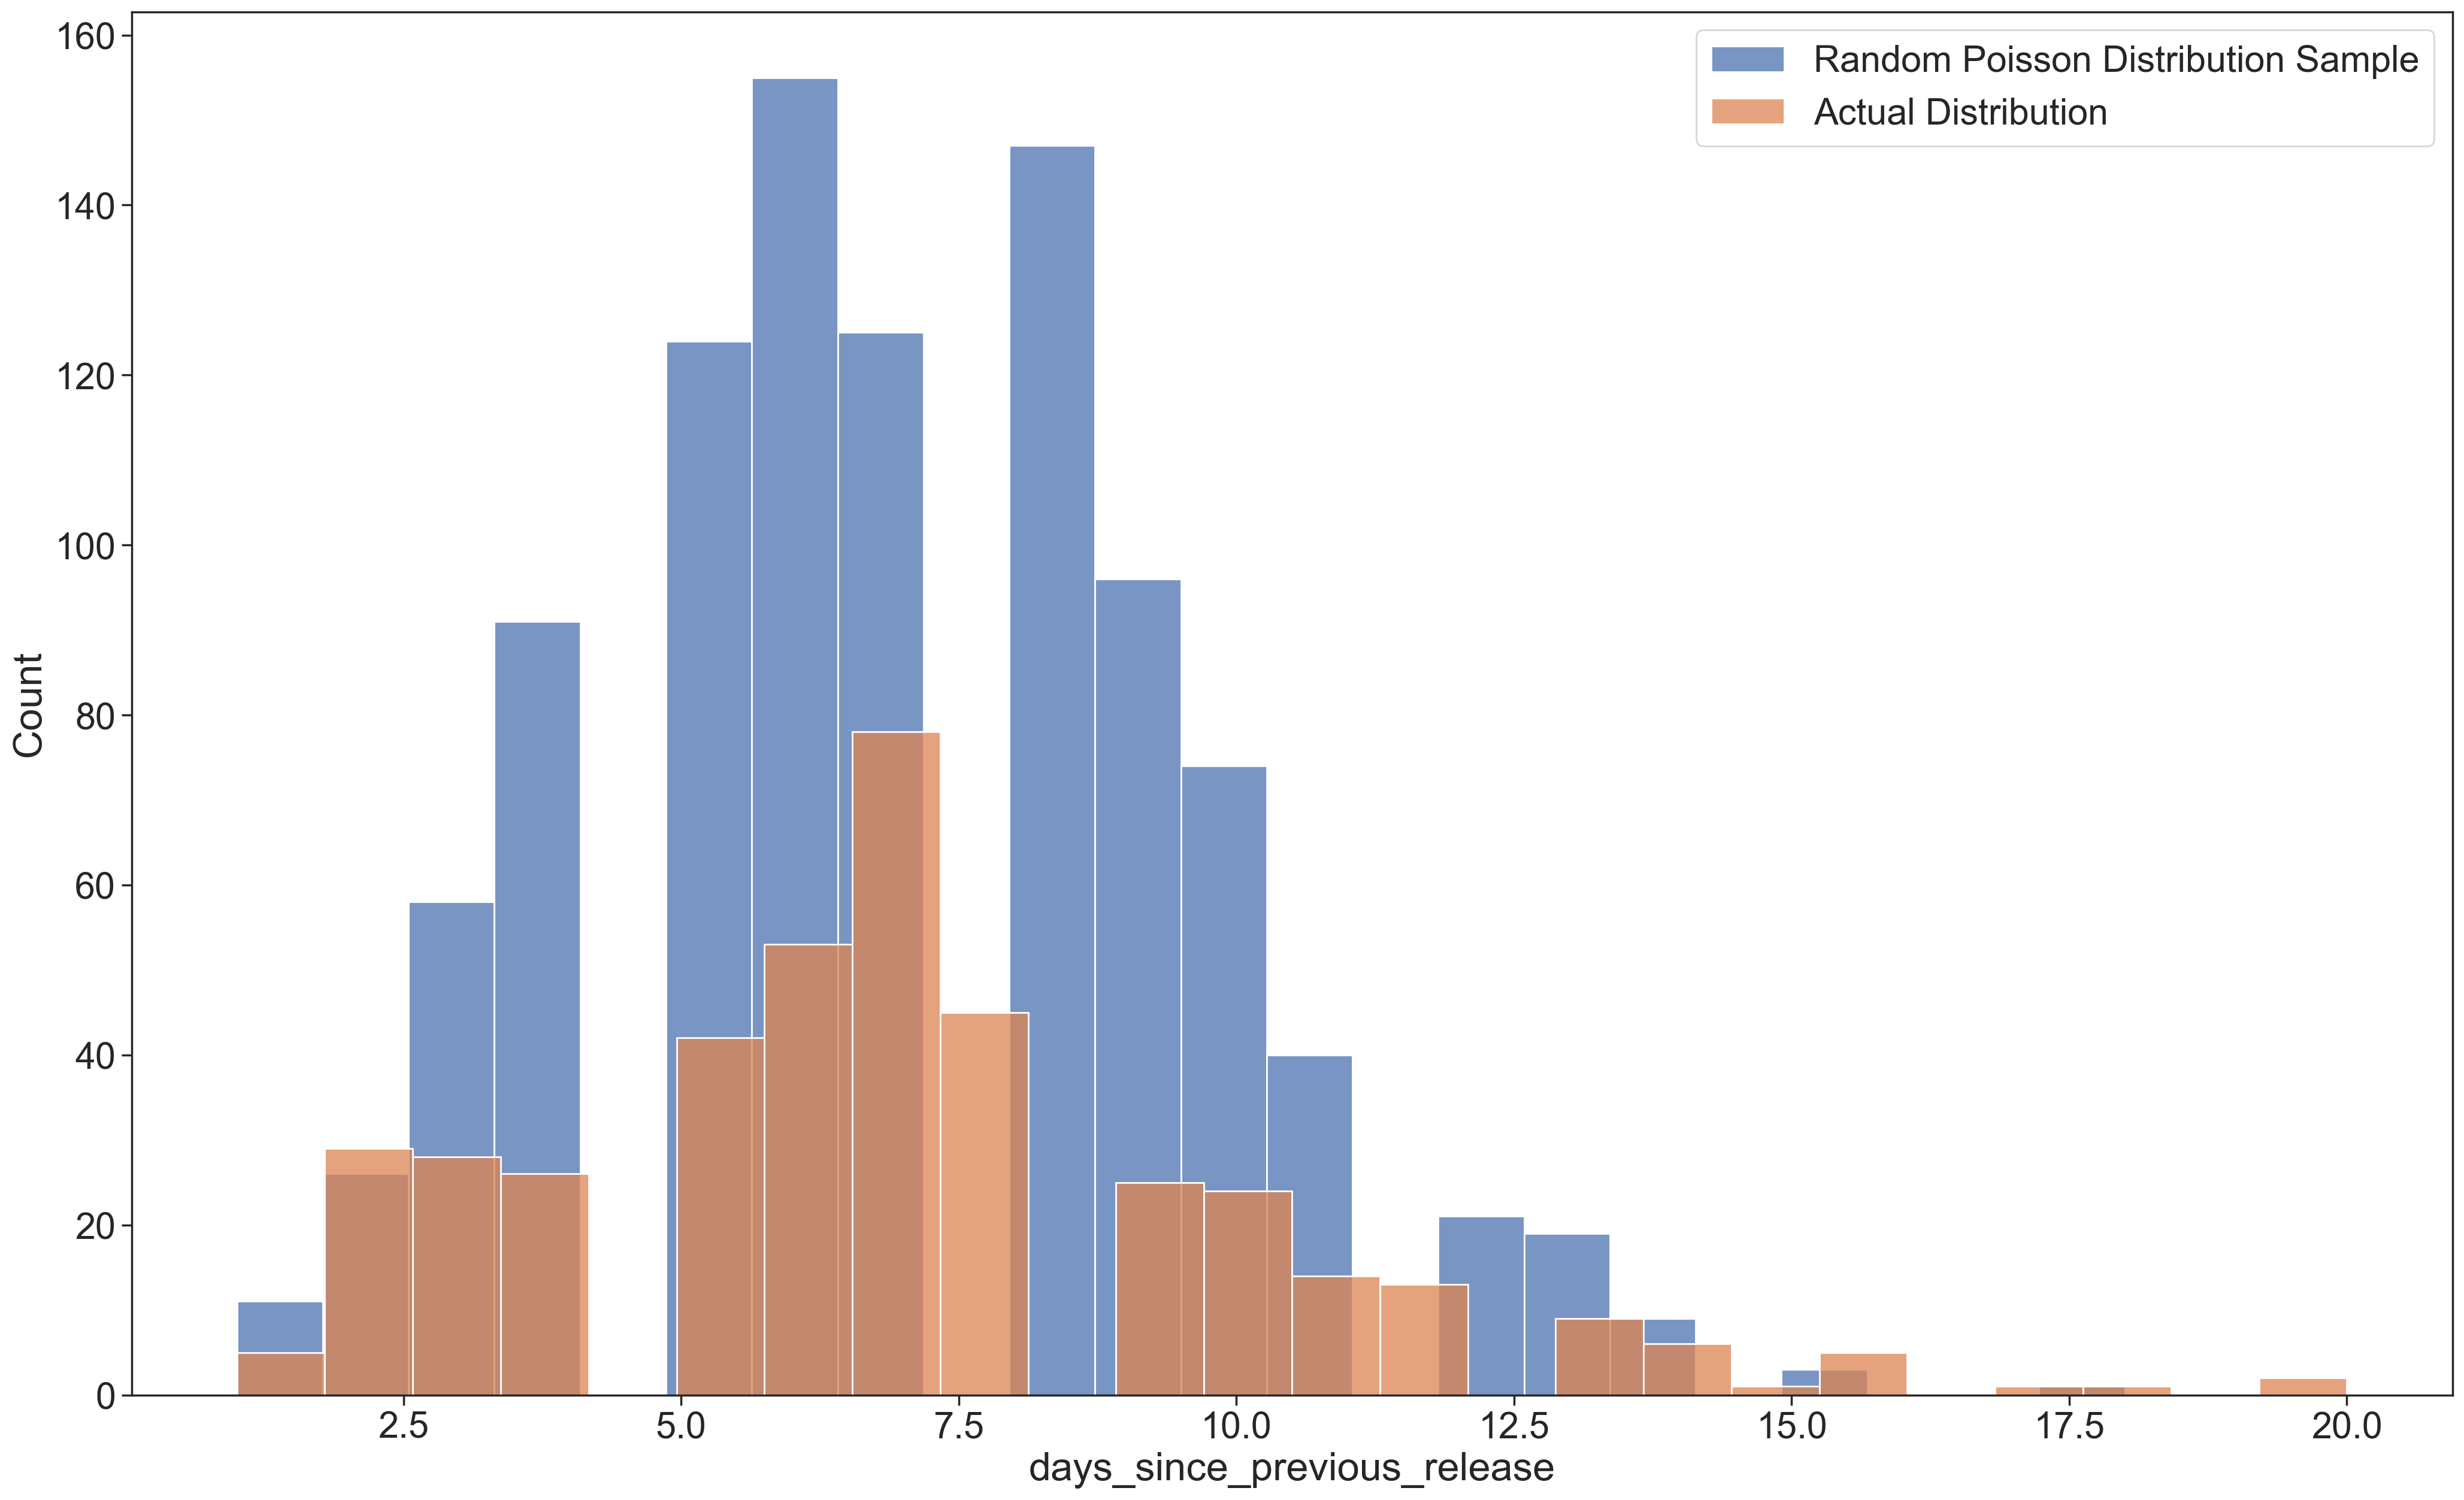

In [6]:
ax = sns.histplot(poisson.rvs(7, size=1000), label="Random Poisson Distribution Sample")
sns.histplot(x=df[df["release"] == 1]["days_since_previous_release"], ax=ax, label="Actual Distribution")
ax.legend()
plt.show()

In [7]:
df[df["release"] == 1]["days_until_next_release"].mean()

6.943488943488943

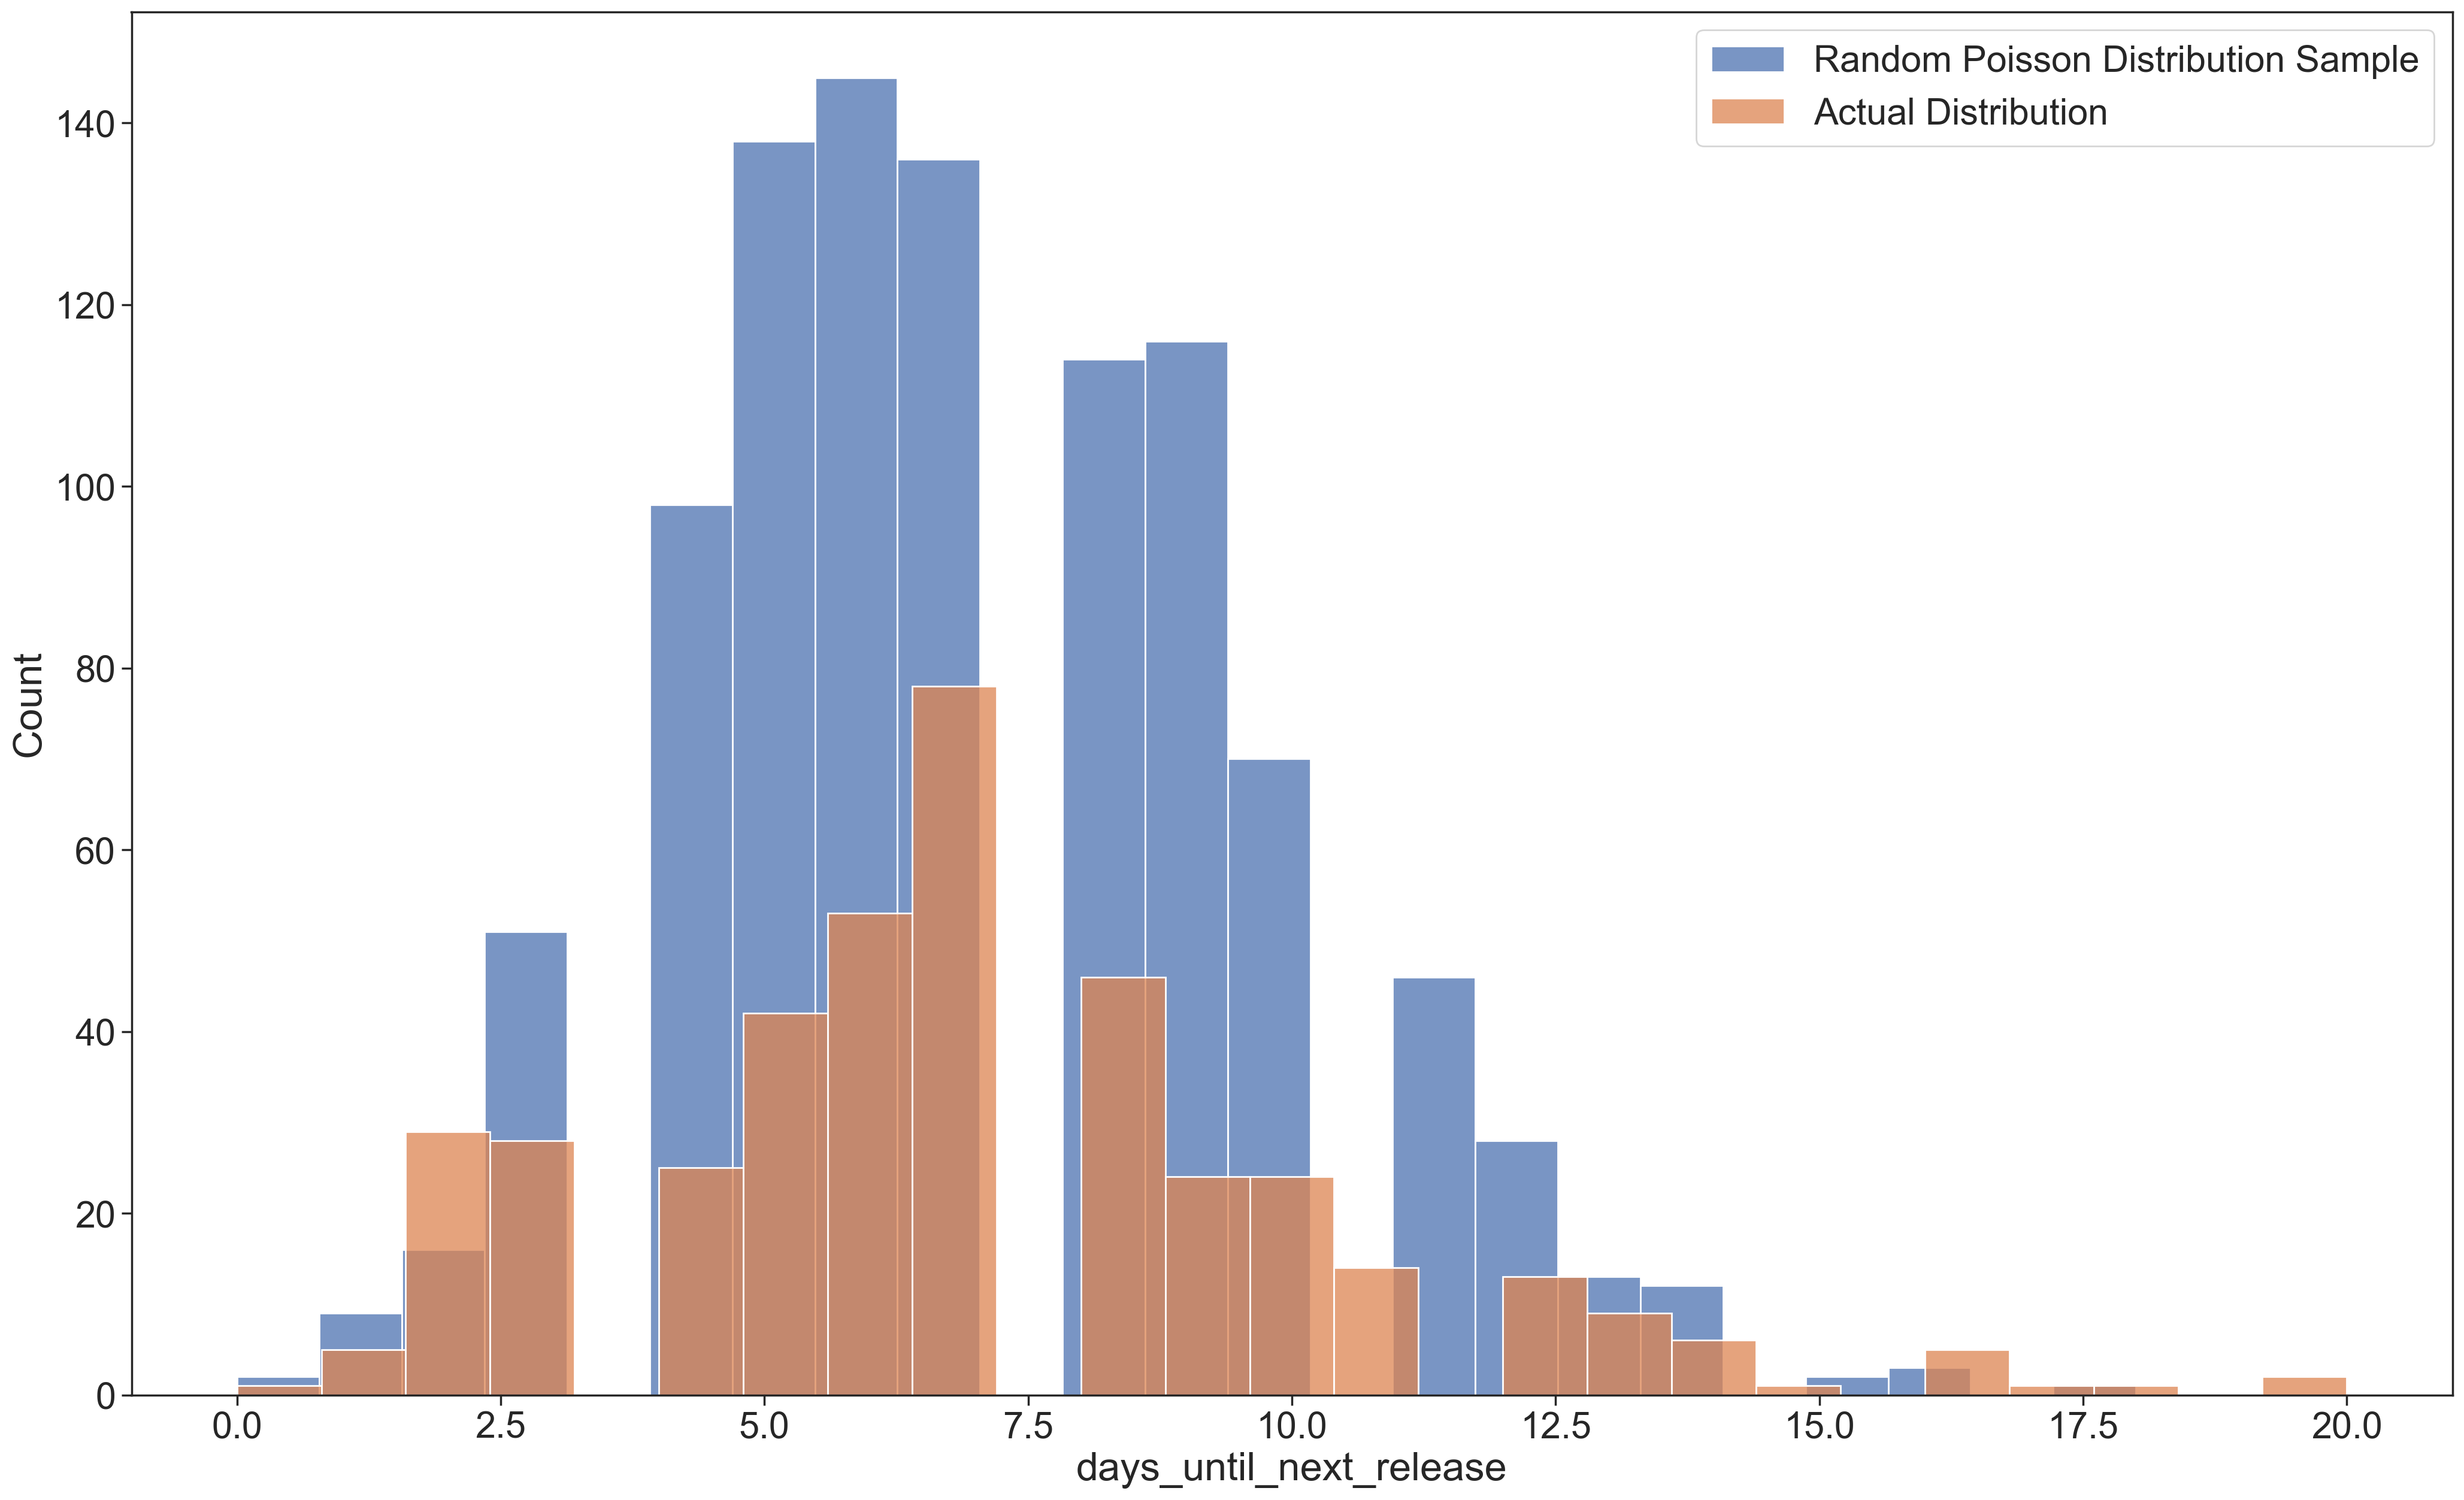

In [8]:
ax = sns.histplot(poisson.rvs(6.955665024630542, size=1000), label="Random Poisson Distribution Sample")
sns.histplot(x=df[df["release"] == 1]["days_until_next_release"], ax=ax, label="Actual Distribution")
ax.legend()
plt.show()

In [10]:
# sns.histplot(x=df[df["release"] == 1]["month_holidays"])

<Axes: xlabel='days_until_next_holiday', ylabel='Count'>

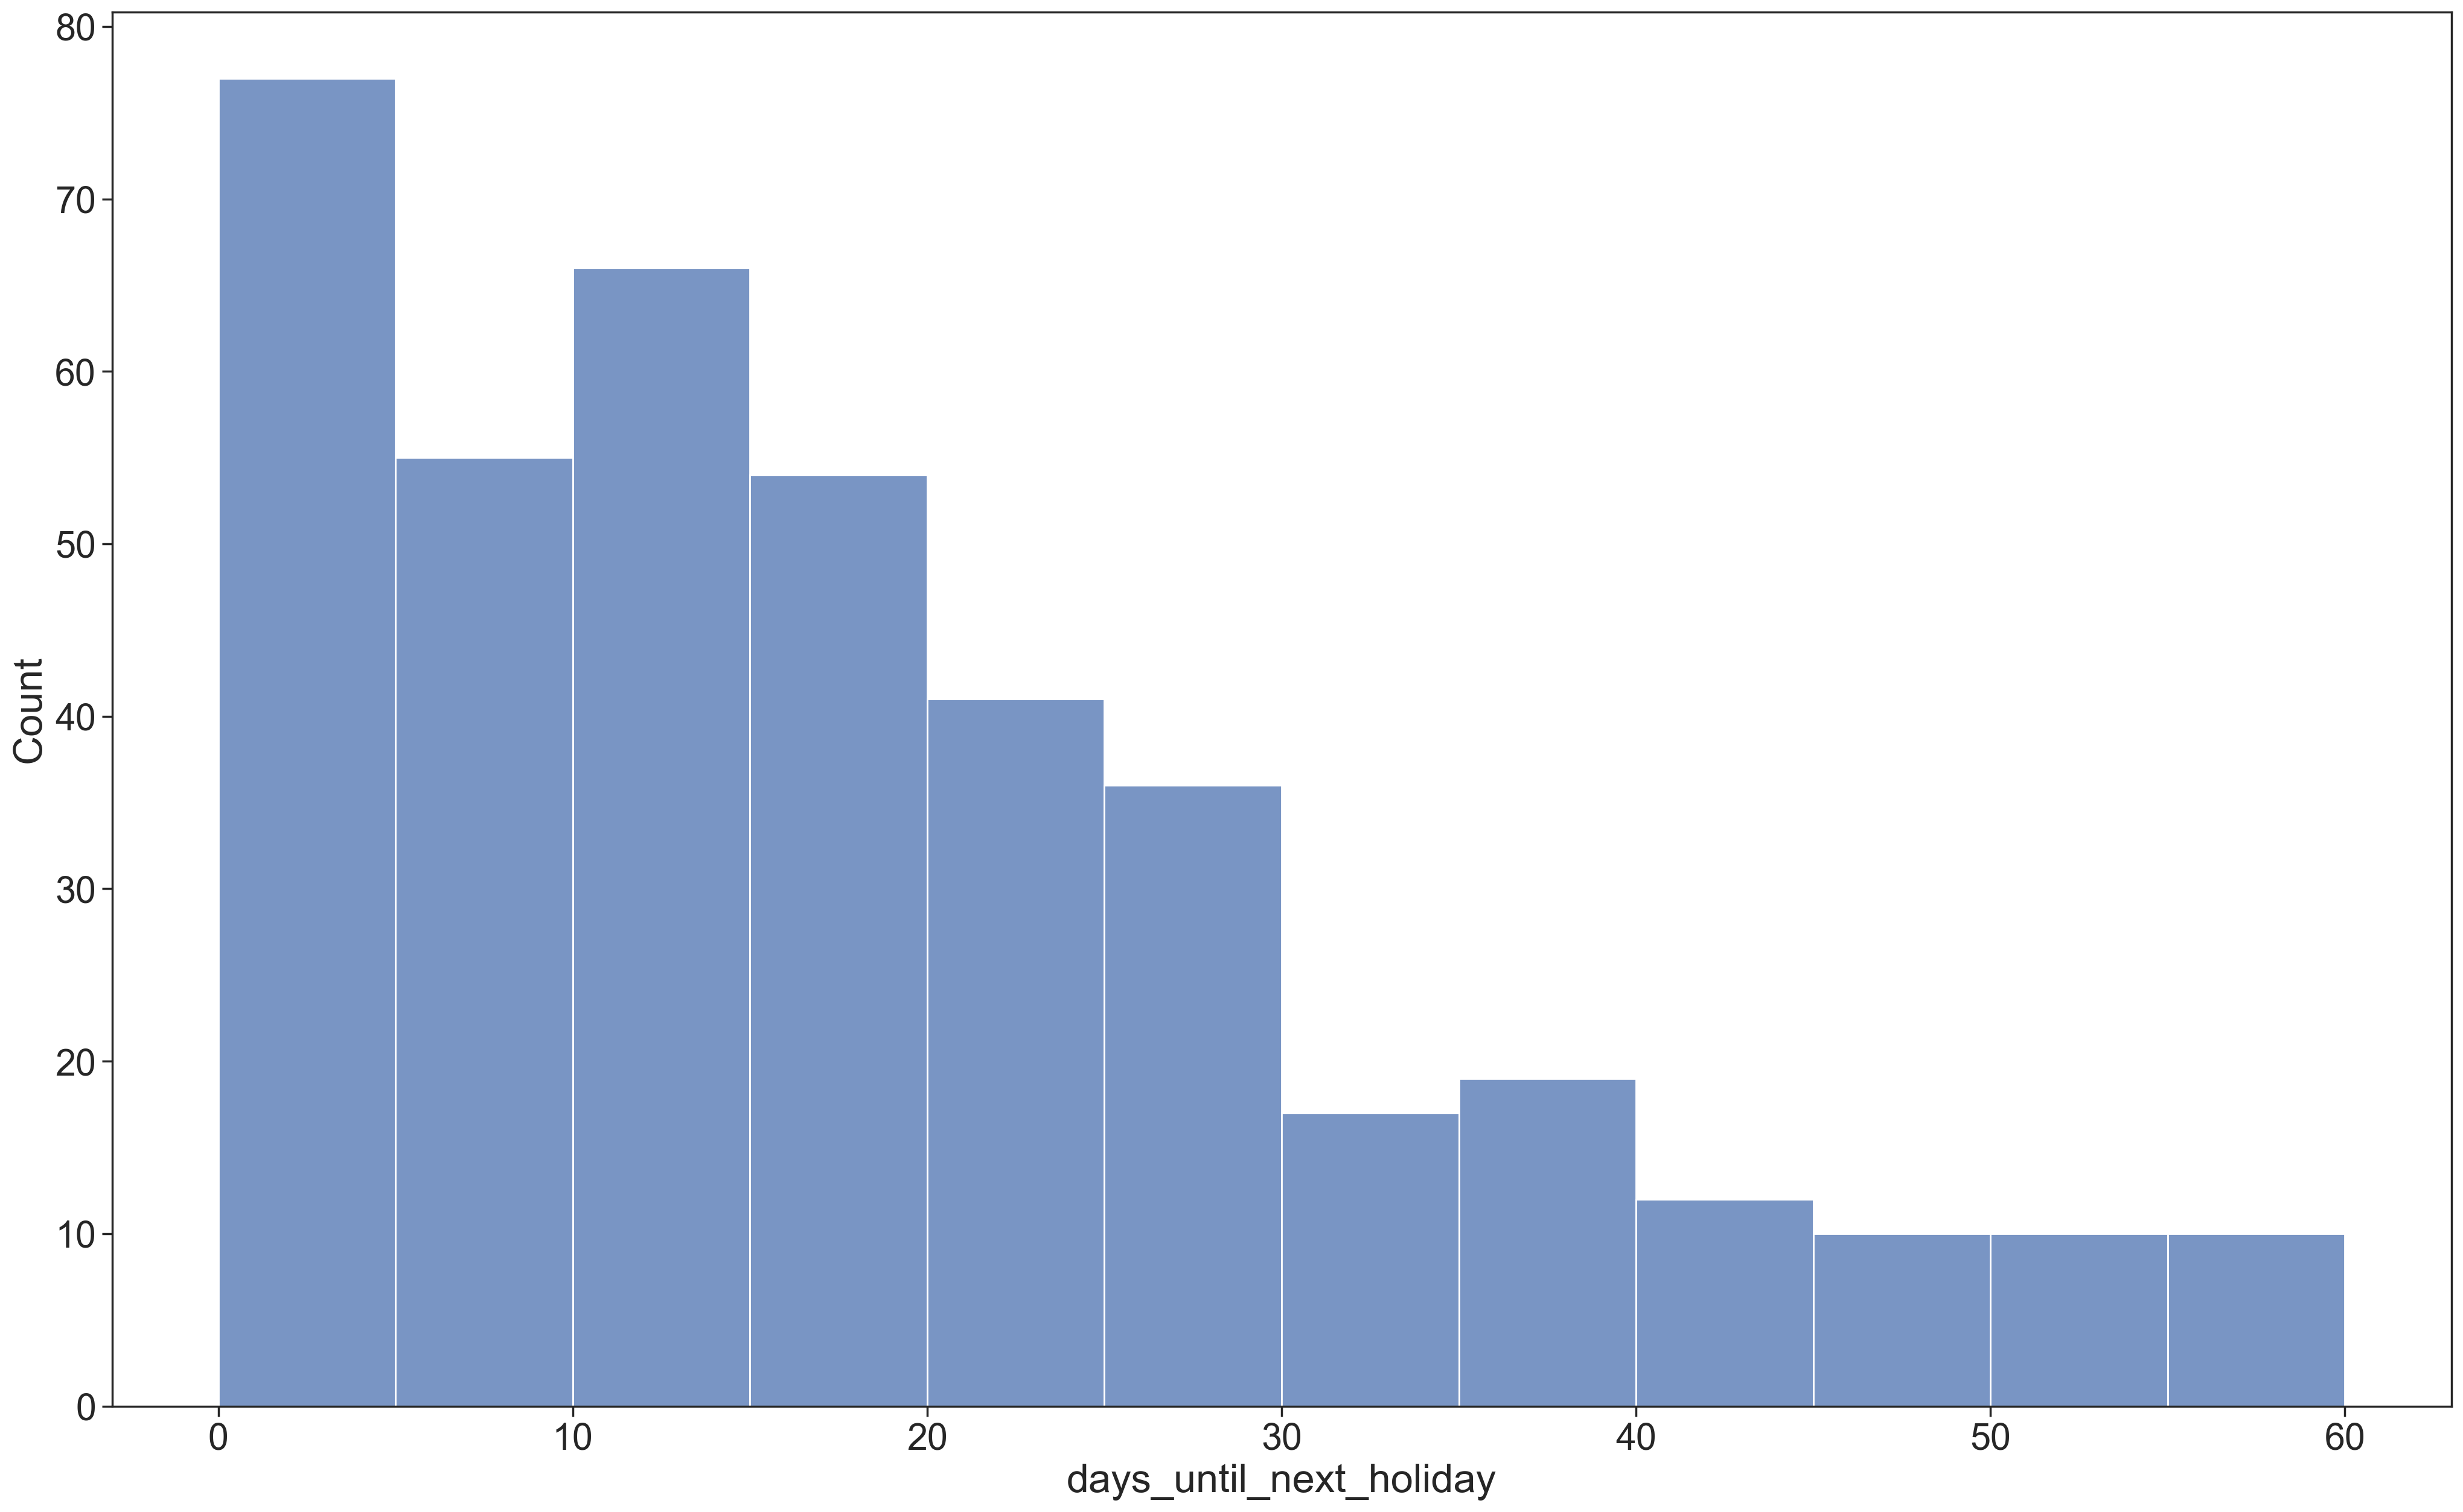

In [11]:
sns.histplot(x=df[df["release"] == 1]["days_until_next_holiday"])

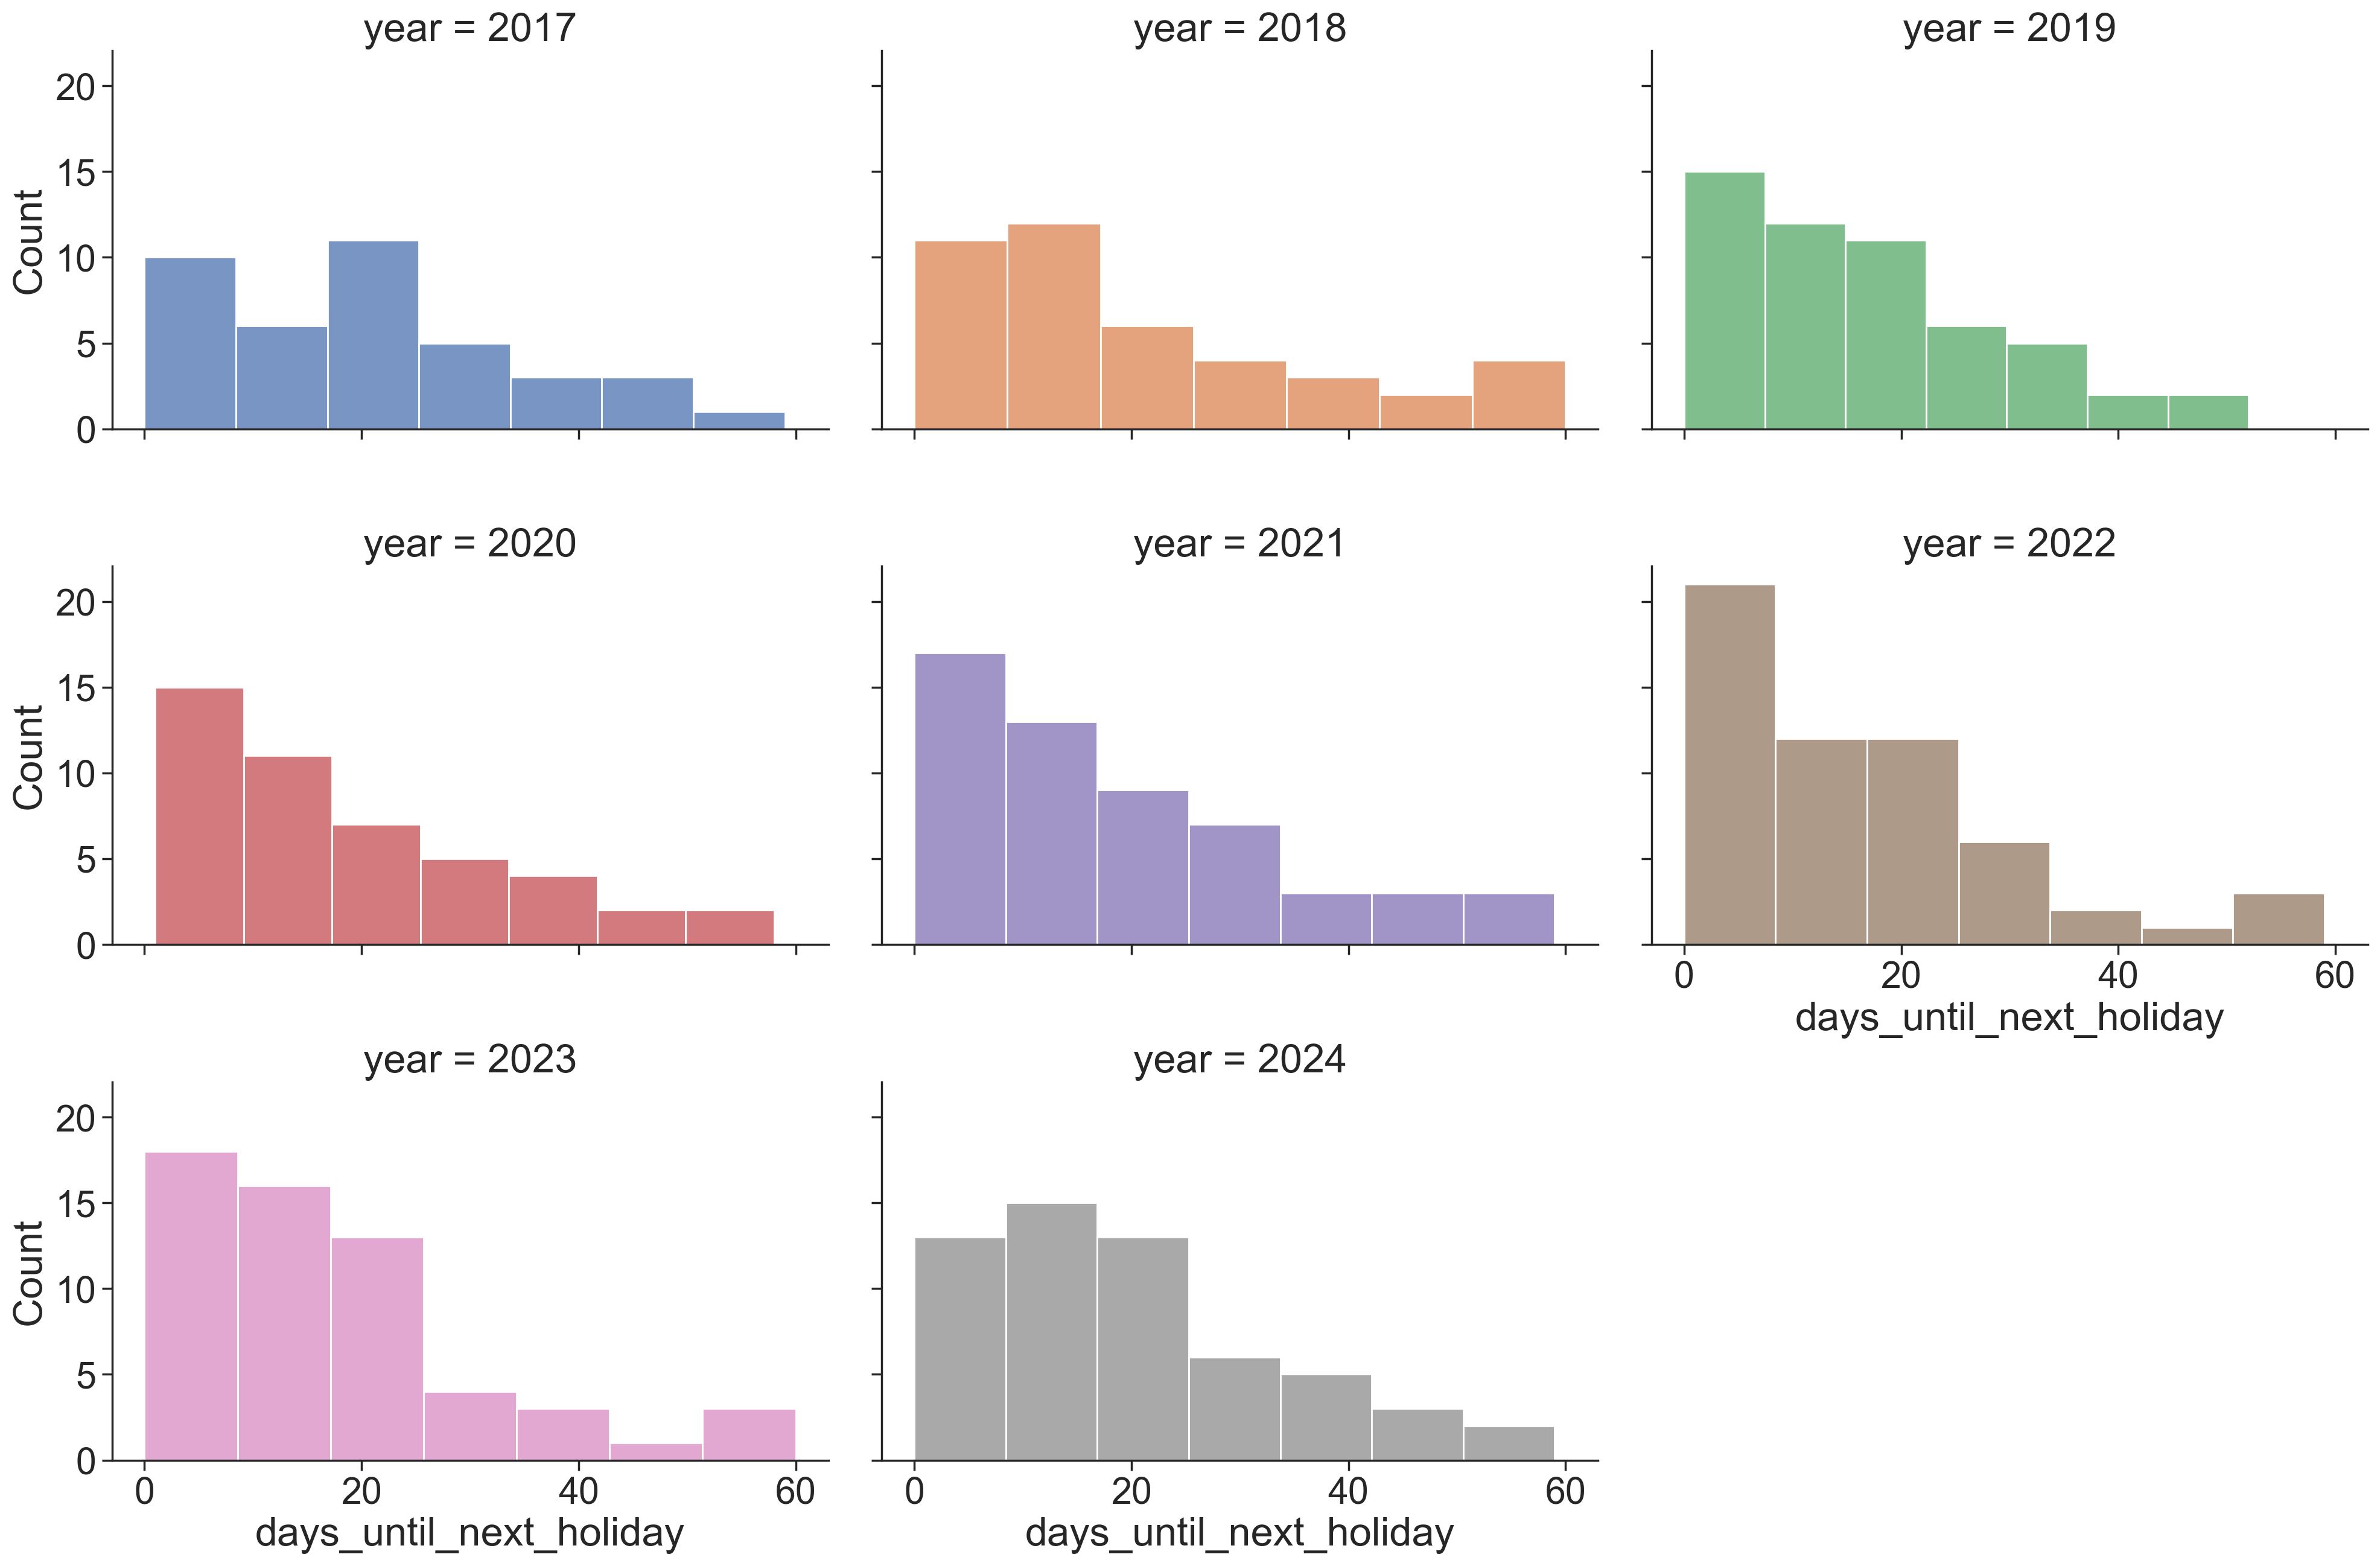

In [12]:
g = sns.FacetGrid(df[df["release"] == 1], col="year", col_wrap=3, aspect=1.5, height=4.5, hue="year")
g.map(sns.histplot, "days_until_next_holiday")
# g.set_xlabels("")
plt.tight_layout()

---

In [13]:
release_df = df[df["release"] == 1].copy()

In [14]:
# release_df[release_df["year"] >= 2019].corr(numeric_only=True).dropna(how="all").dropna(how="all", axis=1)

In [25]:
years = None

for year in set(release_df["year"]):
    s = release_df[release_df["year"] == year]["days_since_previous_release"].reset_index()
    s = s["days_since_previous_release"]
    s.name = year
    if years is None:
        years = pandas.DataFrame(s)
    else:
        years = years.join(s, how="outer")

years.corr()

,2017,2018,2019,2020,2021,2022,2023,2024
2017,1.000000,-0.263893,-0.221345,0.066477,-0.101801,0.104277,0.099133,0.012278
2018,-0.263893,1.000000,0.231755,0.017360,0.366981,-0.057464,-0.084272,-0.109111
2019,-0.221345,0.231755,1.000000,-0.007101,0.289617,-0.100874,-0.001079,0.022012
2020,0.066477,0.017360,-0.007101,1.000000,0.064451,0.029493,-0.006257,0.034721
2021,-0.101801,0.366981,0.289617,0.064451,1.000000,0.078449,0.185419,-0.035974
2022,0.104277,-0.057464,-0.100874,0.029493,0.078449,1.000000,0.043599,-0.182709
2023,0.099133,-0.084272,-0.001079,-0.006257,0.185419,0.043599,1.000000,0.074713
2024,0.012278,-0.109111,0.022012,0.034721,-0.035974,-0.182709,0.074713,1.000000


In [26]:
years.describe()

,2017,2018,2019,2020,2021,2022,2023,2024
count,39.000000,42.000000,53.000000,46.000000,55.000000,57.000000,58.000000,57.000000
mean,8.076923,8.547619,7.037736,7.630435,6.763636,6.456140,6.293103,5.754386
std,3.779339,3.883689,4.336616,2.388479,3.310833,2.420671,2.649122,2.487689
min,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000
25%,6.000000,7.000000,3.000000,6.000000,5.000000,5.000000,4.000000,4.000000
50%,7.000000,8.000000,7.000000,7.000000,6.000000,6.000000,6.500000,6.000000
75%,9.500000,11.750000,10.000000,9.000000,8.000000,8.000000,8.000000,7.000000
max,20.000000,16.000000,20.000000,16.000000,16.000000,14.000000,14.000000,12.000000


---

In [132]:
lr = LinearRegression()
lr.fit(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

LinearRegression()

In [133]:
lr.score(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

0.027050721685498602

In [134]:
lr.coef_

array([-0.16516366])

In [135]:
lr.intercept_

8.106522127887867

In [136]:
release_df[["days_since_previous_release", "days_until_next_release"]].mean()

days_since_previous_release    6.967980
days_until_next_release        6.955665
dtype: float64

In [137]:
release_df[["days_since_previous_release", "days_until_next_release"]].std()

days_since_previous_release    3.273004
days_until_next_release        3.286787
dtype: float64

In [138]:
pr = PoissonRegressor()
pr.fit(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

PoissonRegressor()

In [139]:
pr.score(release_df[["days_since_previous_release"]], release_df["days_until_next_release"])

0.02745731286074915

In [140]:
pr.coef_

array([-0.02414678])

In [141]:
pr.intercept_

2.1047587859694152

In [142]:
release_df["pred"] = pr.predict(release_df[["days_since_previous_release"]])

In [143]:
release_df[["days_until_next_release", "pred"]]

,days_until_next_release,pred
0,20.0,6.602430
20,6.0,5.062311
26,6.0,7.098462
32,9.0,7.098462
41,8.0,6.602430
...,...,...
2798,6.0,6.929110
2804,6.0,7.098462
2810,6.0,7.098462
2816,8.0,7.098462


In [13]:
lr = LinearRegression().fit(release_df[["days_until_next_holiday"]], release_df["days_until_next_release"])

In [14]:
lr.score(release_df[["days_until_next_holiday"]], release_df["days_until_next_release"])

0.0006130824233745447

In [15]:
lr.intercept_

7.045214176871963

In [16]:
lr.coef_

array([-0.00558432])

---

In [145]:
df = df.set_index("index")

In [146]:
df.resample("W")["release"].sum().value_counts()

release
1    263
0     71
2     70
3      1
Name: count, dtype: Int64

In [147]:
df.resample("W")["release"].sum().value_counts() / df["release"].sum()

release
1    0.647783
0    0.174877
2    0.172414
3    0.002463
Name: count, dtype: Float64

In [148]:
np.log(0.187845)

-1.6721381242980315

In [149]:
# probability mass function

k = list(range(0, 10)) # number of release per week
p = [] # prob under Poisson distribution
mu = 1.6721381242980315

for i in k:
    p.append(np.exp(mu * -1) * ((mu ** i) / factorial(i)))

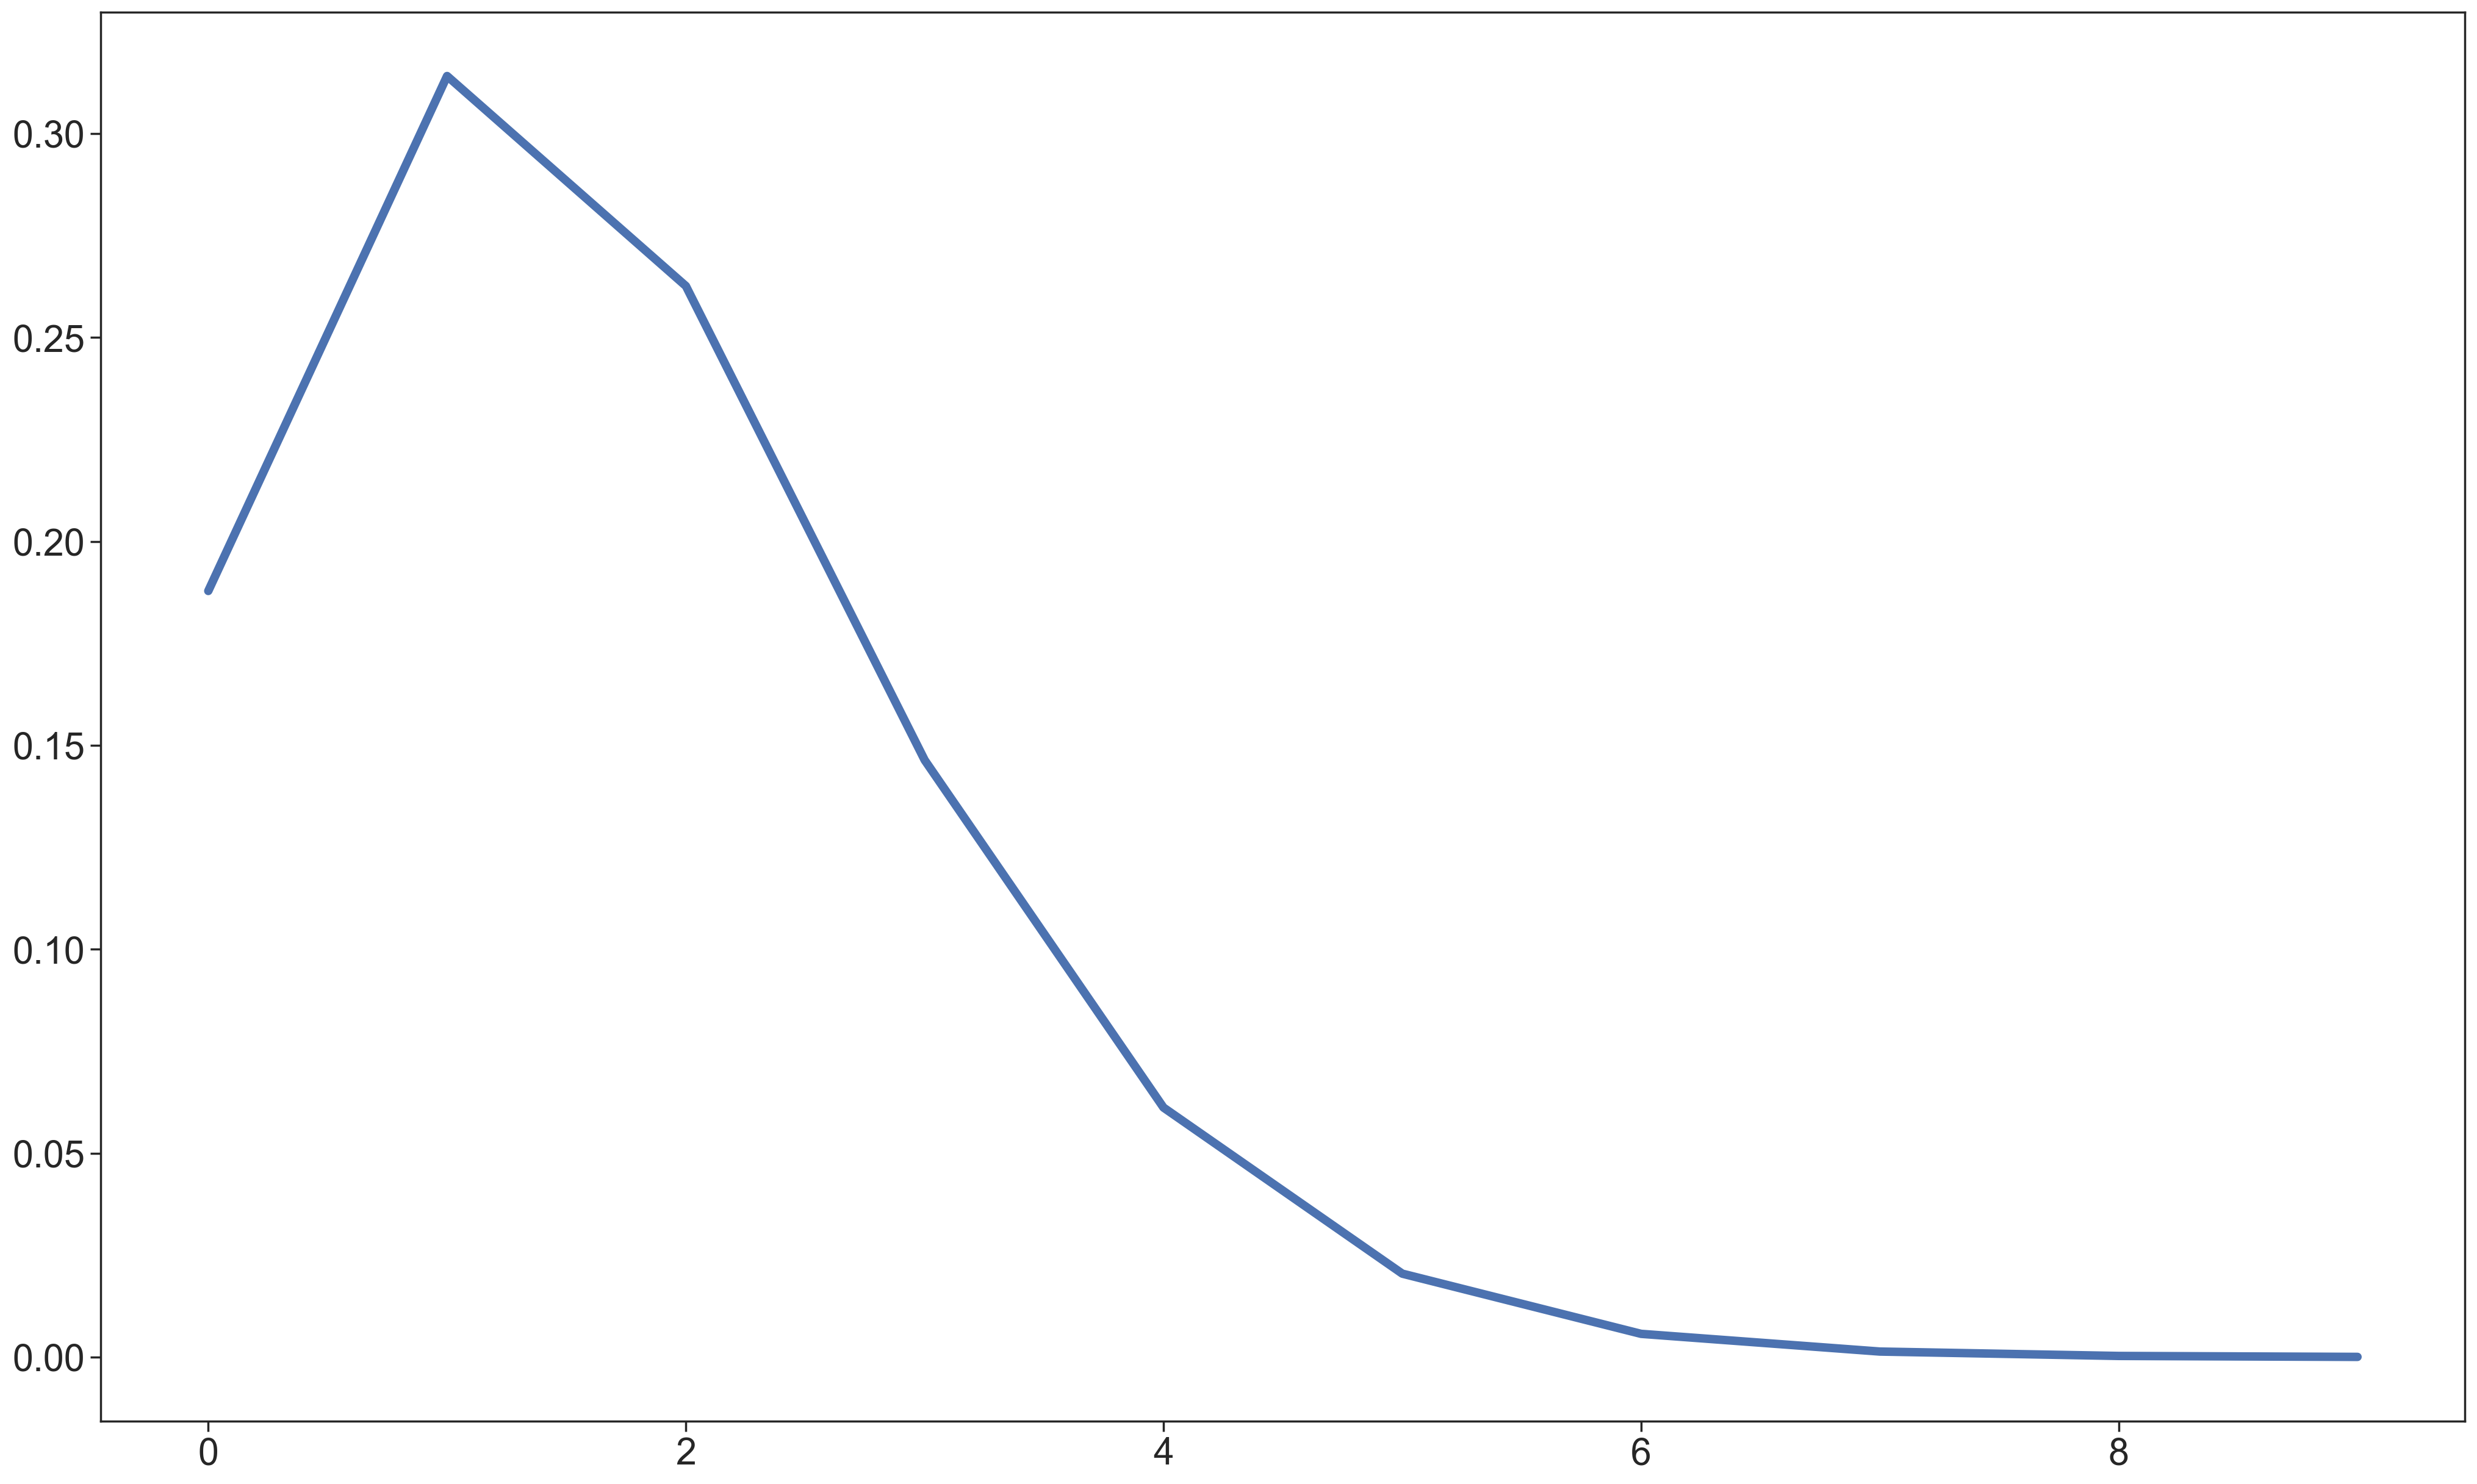

In [150]:
ax = sns.lineplot(x=k, y=p, linewidth=5)
plt.show()

In [151]:
poisson.pmf(mu=mu, k=1)

0.3141027859587638

In [152]:
p

[0.187845,
 0.31410278595876373,
 0.2626116216749366,
 0.14637430149546427,
 0.06118951248701505,
 0.020463463327349666,
 0.0057029561974726705,
 0.0013623043541422554,
 0.000284745130932309,
 5.290368768223873e-05]

In [153]:
poisson.rvs(mu=mu, loc=((0 + 1 + 2 + 3) / 4), size=100)

array([1, 1, 2, 3, 2, 4, 1, 2, 3, 3, 2, 5, 2, 4, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 3, 3, 3, 1, 2, 1, 2, 4, 2, 3, 3, 1, 3, 1, 3, 2, 3, 2, 1, 2, 1,
       7, 2, 2, 4, 2, 3, 6, 1, 1, 1, 2, 2, 1, 3, 2, 2, 6, 2, 3, 1, 5, 1,
       5, 2, 4, 3, 1, 4, 3, 6, 3, 4, 2, 3, 2, 4, 4, 5, 7, 2, 2, 2, 5, 1,
       3, 2, 1, 6, 4, 2, 3, 2, 2, 2, 2, 4])

In [154]:
(0 + 1 + 2 + 3) / 4

1.5

---

In [155]:
temp = df[df["release"] == 1].copy().reset_index()
temp["index"].dt.year.value_counts() / 52

index
2023    1.115385
2022    1.096154
2024    1.076923
2021    1.057692
2019    1.019231
2020    0.884615
2018    0.807692
2017    0.750000
Name: count, dtype: float64

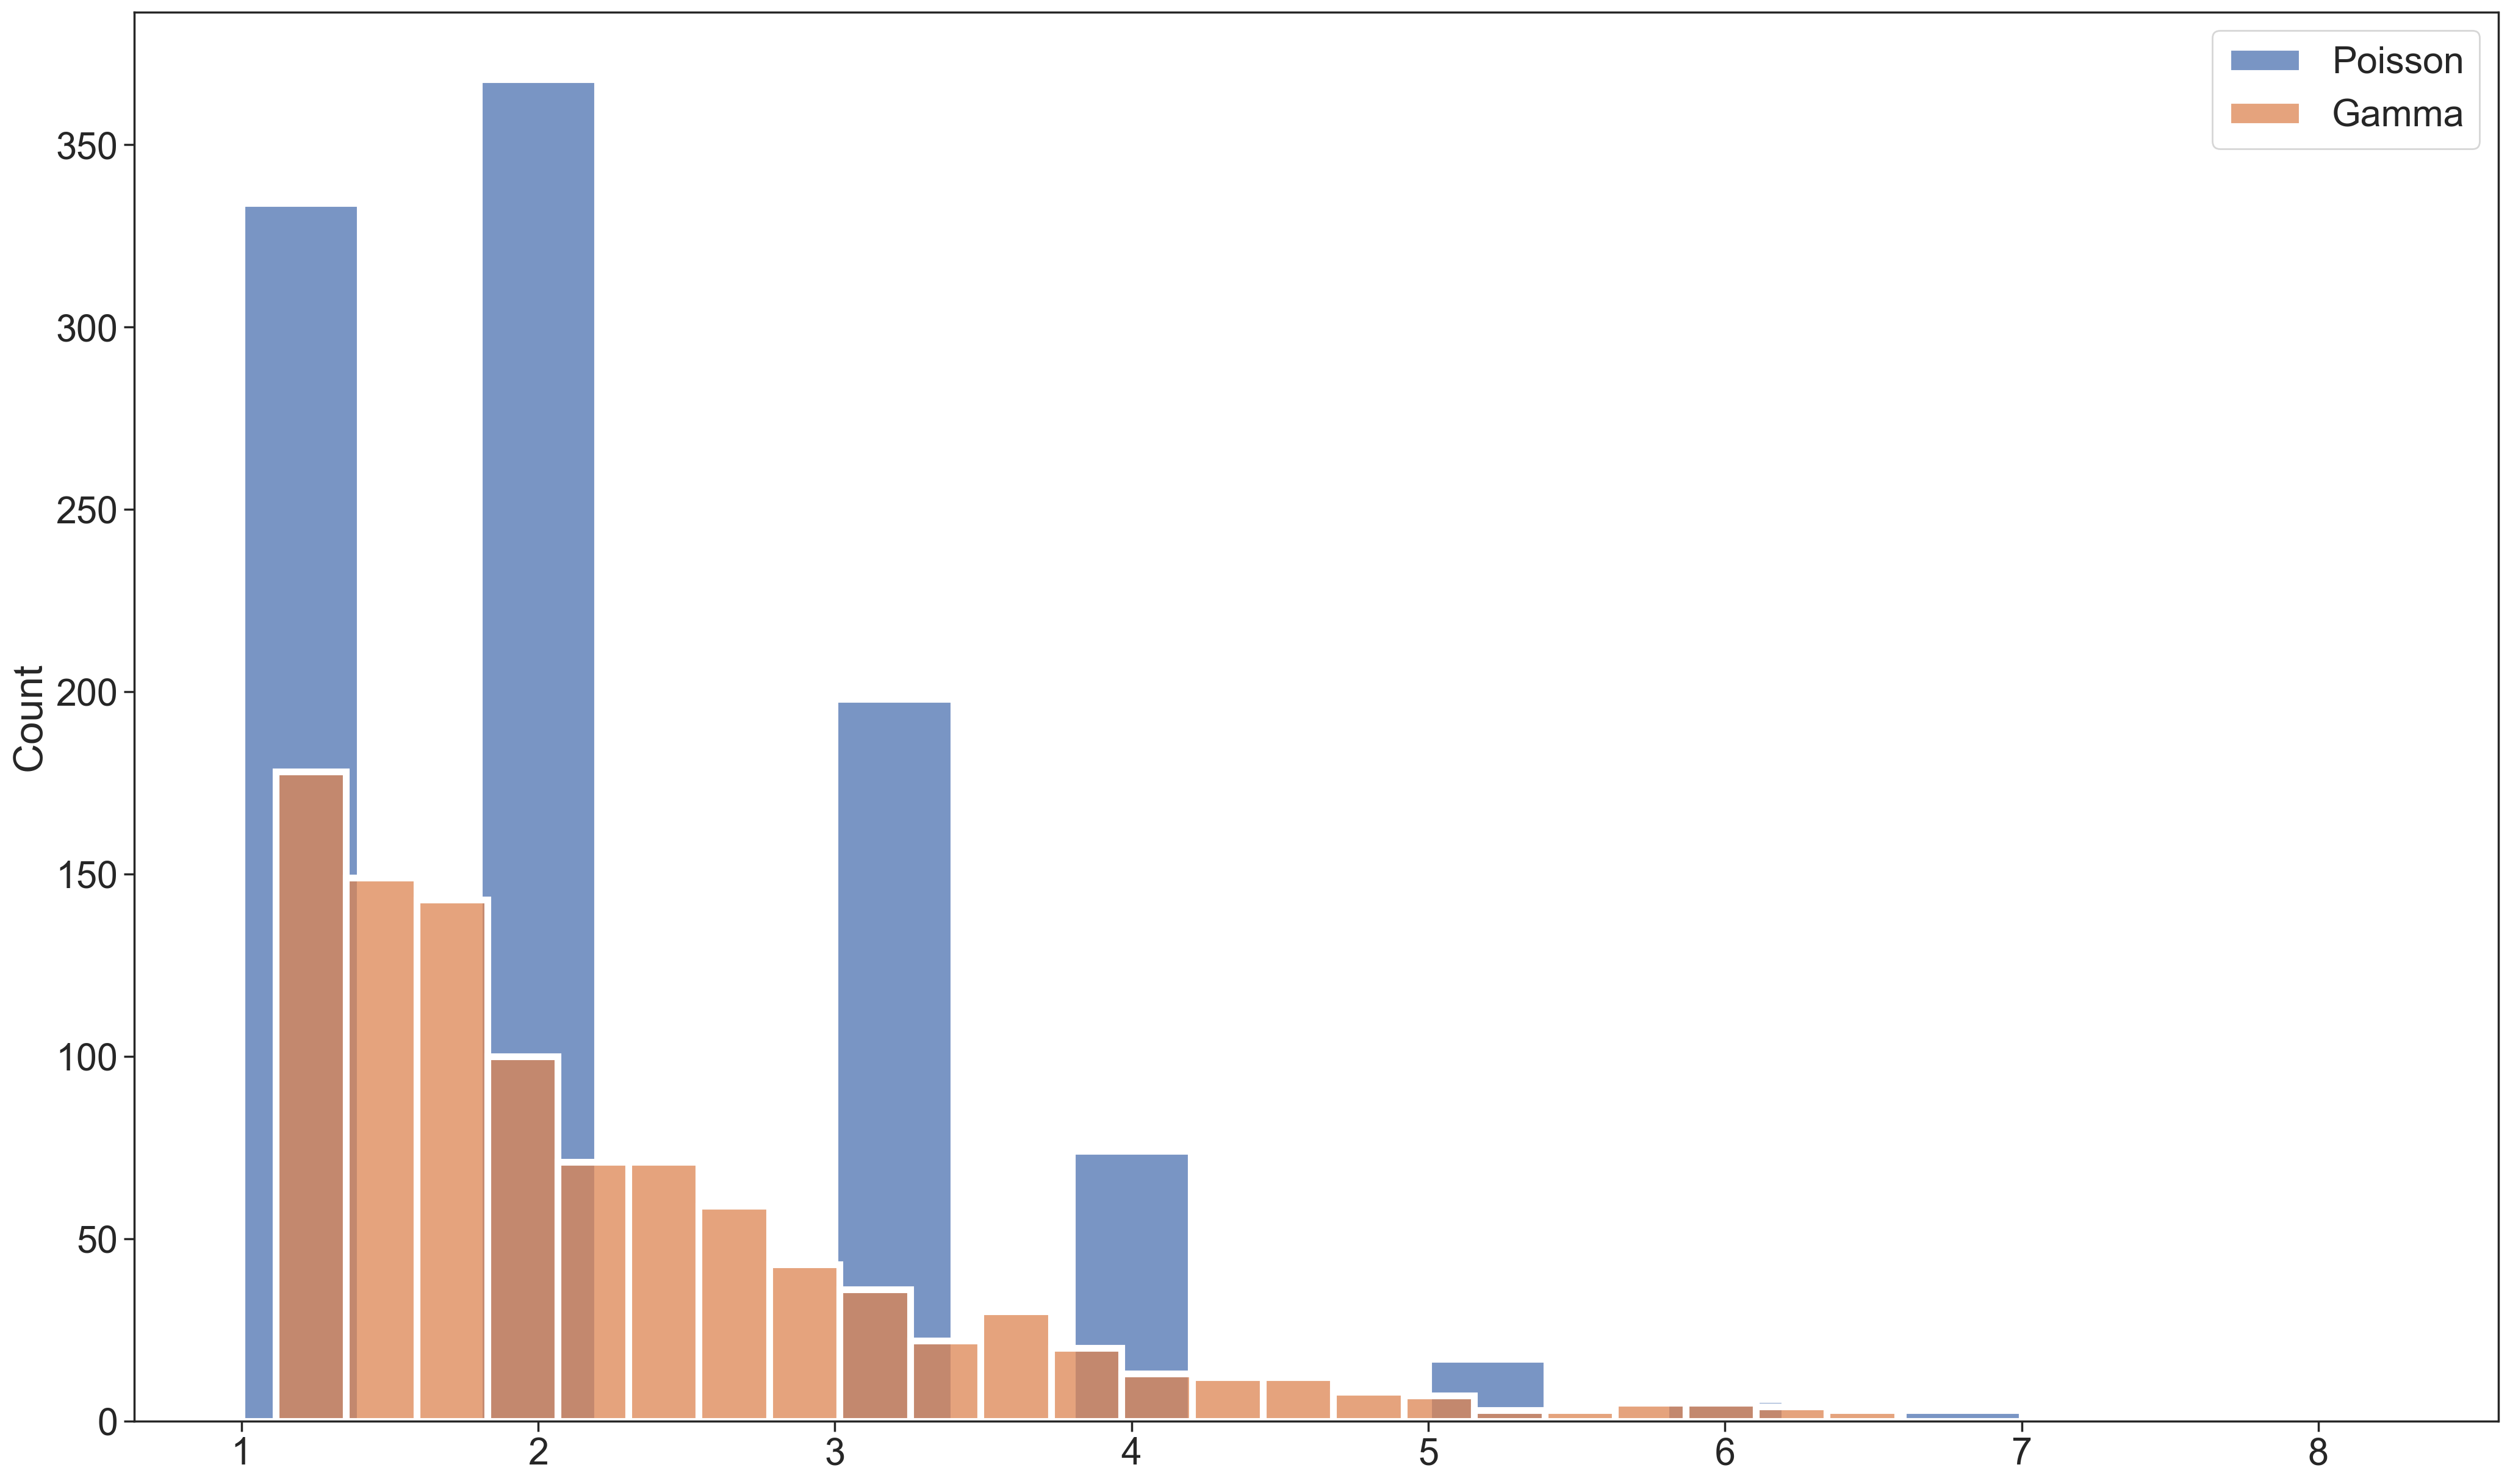

In [156]:
# ax = sns.kdeplot(x=expon.rvs(loc=2, scale=1, size=1000), linewidth=4, label="Exponential")
ax = sns.histplot(x=poisson.rvs(mu=1.115385, loc=1.115385, size=1000), linewidth=4, label="Poisson")
sns.histplot(x=gamma.rvs(a=1.115385, loc=1.115385, size=1000), linewidth=4, label="Gamma", ax=ax)
ax.legend()
plt.show()

---

In [157]:
train_df = train_df[train_df["release"] == 1].reset_index()
test_df = test_df[test_df["release"] == 1].reset_index()

In [158]:
ar = AutoReg(train_df["days_until_next_release"],
             lags=7).fit()
             # exog=train_df[["days_since_previous_release"]]).fit()

In [159]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AutoReg Model Results                               
===================================================================================
Dep. Variable:     days_until_next_release   No. Observations:                  350
Model:                          AutoReg(7)   Log Likelihood                -872.861
Method:                    Conditional MLE   S.D. of innovations              3.083
Date:                     Thu, 21 Nov 2024   AIC                           1763.722
Time:                             16:26:25   BIC                           1798.261
Sample:                                  7   HQIC                          1777.480
                                       350                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.7878      1.085      4.414      0.000       2.662       6.914
days_until_next_release.L1    -0.2603      0.053     -4.945      0.000      -0.363      -0.157
days_until_next_release.L2    -0.0802      0.054     -1.490      0.136      -0.186       0.025
days_until_next_release.L3     0.0034      0.053      0.064      0.949      -0.101       0.108
days_until_next_release.L4     0.1204      0.053      2.282      0.023       0.017       0.224
days_until_next_release.L5     0.1838      0.053      3.453      0.001       0.079       0.288
days_until_next_release.L6     0.1828      0.054      3.390      0.001       0.077       0.288
days_until_next_release.L7     0.1780      0.052      3.444      0.001       0.077       0.279
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1388           -0.0000j            1.1388           -0.0000
AR.2            0.5631           -1.1138j            1.2481           -0.1755
AR.3            0.5631           +1.1138j            1.2481            0.1755
AR.4           -0.4292           -1.2721j            1.3426           -0.3018
AR.5           -0.4292           +1.2721j            1.3426            0.3018
AR.6           -1.2167           -0.5258j            1.3254           -0.4351
AR.7           -1.2167           +0.5258j            1.3254            0.4351
-----------------------------------------------------------------------------
"""

In [160]:
test_df["pred"] = ar.forecast(steps=len(test_df)).values
                              # exog=test_df[["days_since_previous_release"]]).values

In [161]:
wape(test_df["days_until_next_release"], test_df["pred"])

0.38559233968964796

In [162]:
test_df[["days_until_next_release", "pred"]]

,days_until_next_release,pred
0,7.0,7.623528
1,6.0,6.849188
2,6.0,6.117969
3,2.0,6.475527
4,7.0,6.623722
5,12.0,6.244094
6,7.0,7.110703
7,2.0,6.972272
8,6.0,6.749545
9,7.0,6.738276
